In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import copy
import warnings
from matplotlib import pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

### Data are downloaded from [Wharton Research Data Services]('https://wrds-web.wharton.upenn.edu/wrds/')

In [2]:
b2m=pd.read_csv('D:/UT MSBA Spring 2019/Quant Investment/hw4/B2M.csv')
crsp=pd.read_csv('D:/UT MSBA Spring 2019/Quant Investment/hw4/CRSP_data_HW4.csv')
ff=pd.read_csv('D:/UT MSBA Spring 2019/Quant Investment/hw4/F-F_Research_Data_Factors.csv')

In [3]:
# Copied data to prevent changing original data
d1=copy.deepcopy(b2m)
d2=copy.deepcopy(crsp)
d3=copy.deepcopy(ff)

In [4]:
d1.head()

,permno,public_date,bm
0,10001,31-Jan-03,0.889
1,10001,28-Feb-03,1.030
2,10001,31-Mar-03,1.030
3,10001,30-Apr-03,1.030
4,10001,31-May-03,1.071


In [5]:
pd.concat([d2.head(),d2.tail()])

,PERMNO,date,TICKER,PRC,RET,SHROUT,vwretd,sprtrn
0,10001,31JAN2003,EWST,8.44000,0.148143,2591.0,-0.023400,-0.027415
1,10001,28FEB2003,EWST,8.74000,0.035545,2591.0,-0.015391,-0.017004
2,10001,31MAR2003,EWST,7.65000,-0.109268,2593.0,0.010318,0.008358
3,10001,30APR2003,EWST,5.17000,-0.324183,2593.0,0.082750,0.081044
4,10001,30MAY2003,EWST,8.44000,0.632495,2594.0,0.063436,0.050899
1353570,93436,31AUG2018,TSLA,301.66000,0.011806,170593.0,0.030221,0.030263
1353571,93436,28SEP2018,TSLA,264.76999,-0.122290,171578.0,0.000443,0.004294
1353572,93436,31OCT2018,TSLA,337.32001,0.274011,171733.0,-0.074031,-0.069403
1353573,93436,30NOV2018,TSLA,350.48001,0.039013,171733.0,0.018530,0.017859
1353574,93436,31DEC2018,TSLA,332.79999,-0.050445,171733.0,-0.089810,-0.091777


In [6]:
d3.head()

,Month,Mkt-RF,SMB,HML,RF
0,200301,-2.57,1.39,-0.93,0.10
1,200302,-1.88,-0.34,-1.46,0.09
2,200303,1.09,0.89,-2.09,0.10
3,200304,8.22,0.57,1.03,0.10
4,200305,6.05,4.70,-0.30,0.09


## Preprocessing Data before Analysis

In [7]:
# Change into timestamp
d1.public_date=pd.to_datetime(d1.public_date, format='%d-%b-%y')
d2.date=pd.to_datetime(d2.date, format='%d%b%Y')
d3.Month=pd.to_datetime(d3.Month, format='%Y%m')

In [8]:
# Exclude values with missing return for several months
no_stocks=d2[(d2.RET=='B')|(d2.RET=='C')].PERMNO.drop_duplicates()
d4=d2[d2.PERMNO.isin(no_stocks)==False]
# Change prices with negative value to positive. Checked that price should be positive based on RET column
d4.PRC=d4.PRC.abs()
d4.RET=pd.to_numeric(d4.RET)

## 1. Smallest 10% market capitalization (str1)

In [9]:
# Function that takes smallest 10% market cap
def get_tickers1(df):
    number=int(round(len(df.PERMNO.drop_duplicates())*0.1))
    df['mc']=df.PRC_t*df.SHROUT_t
    smallest_mc=df.mc.sort_values(ascending=True)[:number]
    tickers=df.PERMNO.loc[smallest_mc.index]
    return tickers

In [10]:
def get_value_weighted_return(df,tickers):
    temp2=df[df.PERMNO.isin(tickers)]
    temp2['mc']=temp2.PRC_t*temp2.SHROUT_t
    weights=temp2.mc/sum(temp2.mc)
    weighted_return=(weights*temp2.RET_n).sum()
    return weighted_return

In [11]:
def get_monthly_return1(date_index):
    this_month=d4[d4.date==dates.loc[date_index]]
    next_month=d4[d4.date==dates.loc[date_index+1]]
    temp=pd.merge(next_month, this_month, how='inner', left_on='PERMNO', right_on='PERMNO', suffixes=('_n','_t'))
    tickers=get_tickers1(temp)
    return get_value_weighted_return(temp,tickers)

In [12]:
dates=Series(d4.date.unique())
str1_mon=Series(dates.index[:-1]).map(get_monthly_return1)
str1_mon_cum=np.cumprod(str1_mon.add(1))

## 2. Top 35% B/M ratio (str2)

In [13]:
def get_tickers2(df):
    number=int(round(len(df.permno.drop_duplicates())*0.35))
    bm=df.bm.sort_values(ascending=False)[:number]
    tickers=df.permno.loc[bm.index]
    return tickers

In [14]:
def get_monthly_return2(date_index):
    this_month=d4[d4.date==dates.loc[date_index]]
    next_month=d4[d4.date==dates.loc[date_index+1]]
    bm=d1[d1.public_date==dates.loc[date_index]]
    temp=pd.merge(next_month, this_month, how='inner', left_on='PERMNO', right_on='PERMNO', suffixes=('_n','_t'))
    tickers=get_tickers2(bm)
    return get_value_weighted_return(temp,tickers)

In [15]:
str2_mon=Series(dates.index[:-1]).map(get_monthly_return2)
str2_mon_cum=np.cumprod(str2_mon.add(1))

## 3. (1, str3) Half-largest and top 35% B/M and (2, str4) Half-smallest and top 35% B/M

In [16]:
def get_tickers3(df1, df2):
    number=int(round(len(df1.PERMNO.drop_duplicates())*0.5))
    df1['mc']=df1.PRC_t*df1.SHROUT_t
    largest=df1.mc.sort_values(ascending=False)[:number]
    smallest=df1.mc.sort_values(ascending=False)[number:]
    large_tickers=df1.PERMNO.loc[largest.index]
    tickers1=get_tickers2(df2[df2.permno.isin(large_tickers)])
    small_tickers=df1.PERMNO.loc[smallest.index]
    tickers2=get_tickers2(df2[df2.permno.isin(small_tickers)])
    return [large_tickers, tickers1, small_tickers, tickers2]

In [17]:
def get_monthly_return3(date_index, large=True):
    this_month=d4[d4.date==dates.loc[date_index]]
    next_month=d4[d4.date==dates.loc[date_index+1]]
    bm=d1[d1.public_date==dates.loc[date_index]]
    temp=pd.merge(next_month, this_month, how='inner', left_on='PERMNO', right_on='PERMNO', suffixes=('_n','_t'))
    values=get_tickers3(temp,bm)
    if large==True:
        large=temp[temp.PERMNO.isin(values[0])]
        monthly_return=get_value_weighted_return(large,values[1])
    else:
        small=temp[temp.PERMNO.isin(values[2])]
        monthly_return=get_value_weighted_return(small,values[3])
    return monthly_return

In [18]:
str3_mon=Series(dates.index[:-1]).map(lambda x : get_monthly_return3(x,large=True))
str3_mon_cum=np.cumprod(str3_mon.add(1))
str4_mon=Series(dates.index[:-1]).map(lambda x : get_monthly_return3(x,large=False))
str4_mon_cum=np.cumprod(str4_mon.add(1))

## 4. Value Weighted Benchmark

In [19]:
def get_monthly_return(date_index):
    this_month=d4[d4.date==dates.loc[date_index]]
    next_month=d4[d4.date==dates.loc[date_index+1]]
    temp=pd.merge(next_month, this_month, how='inner', left_on='PERMNO', right_on='PERMNO', suffixes=('_n','_t'))
    tickers=list(d4.PERMNO.drop_duplicates())
    return get_value_weighted_return(temp,tickers)

In [20]:
#Value weighted all stocks
vw_benchmark=Series(dates.index[:-1]).map(get_monthly_return)
vw_benchmark_cum=np.cumprod(vw_benchmark.add(1))

In [21]:
#Using 'Value Weighted Return Including Dividend' pulled from crsp 
vw_retd=d4[['date','vwretd']].drop_duplicates().vwretd[1:]
vw_retd_cum=np.cumprod(vw_retd.add(1))

In [22]:
returns = DataFrame({'str1':str1_mon.values, 'str2':str2_mon.values, 'str3':str3_mon.values, 'str4':str4_mon.values, 'vw_ben':vw_benchmark.values, 'vw_retd':vw_retd.values}, index=dates[1:])
cum_returns = DataFrame({'str1':str1_mon_cum.values, 'str2':str2_mon_cum.values, 'str3':str3_mon_cum.values, 'str4':str4_mon_cum.values, 'vw_ben':vw_benchmark_cum.values, 'vw_retd':vw_retd_cum.values}, index=dates[1:])
cum_returns.head()

,str1,str2,str3,str4,vw_ben,vw_retd
2003-02-28,0.969716,1.000000,0.972986,1.000000,1.0,0.984609
2003-03-31,0.978148,1.011685,0.979657,1.004975,1.0,0.994768
2003-04-30,1.081925,1.120750,1.080199,1.115918,1.0,1.077085
2003-05-30,1.325299,1.229919,1.184232,1.323205,1.0,1.145411
2003-06-30,1.449678,1.229919,1.184232,1.323205,1.0,1.164104


## Cumulative Return Plot of All Strategies

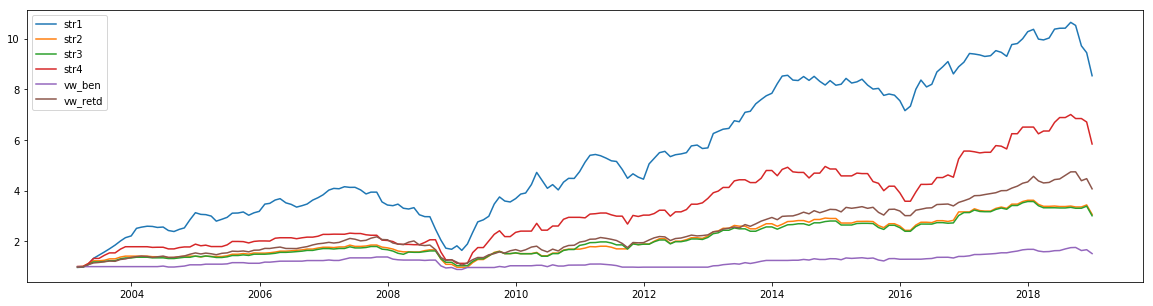

In [23]:
plt.figure(figsize=(20,5))
plt.plot(cum_returns)
plt.legend(list(cum_returns.columns),loc='upper left')
plt.show()

## 5. Sharpe Ratio

In [24]:
risk_free=Series(d3.RF[1:].values,index=dates[1:])/100
summary = pd.DataFrame()
summary['excess_ret_total']=returns.sub(risk_free,axis=0).add(1).resample('A').agg('prod').sub(1).mean()
summary['vol_total']=returns.apply(np.std)*12**0.5
summary['Sharpe_total']=summary.excess_ret_total/summary.vol_total
summary

,excess_ret_total,vol_total,Sharpe_total
str1,0.202241,0.195257,1.035768
str2,0.078996,0.146404,0.539578
str3,0.072806,0.138804,0.524519
str4,0.145340,0.201622,0.720856
vw_ben,0.022306,0.097805,0.228064
vw_retd,0.095043,0.139272,0.682433


### Sharpe Ratio before 2009

In [25]:
summary_1 = pd.DataFrame()
summary_1['excess_ret_before']=returns.sub(risk_free,axis=0).add(1).resample('A').agg('prod').sub(1)[:'2009-01-01'].mean()
summary_1['vol_before']=returns[:'2009-01-01'].apply(np.std)*12**0.5
summary_1['Sharpe_before']=summary_1.excess_ret_before/summary_1.vol_before
summary_1

,excess_ret_before,vol_before,Sharpe_before
str1,0.177796,0.221251,0.803595
str2,0.016702,0.142126,0.117517
str3,0.018853,0.129356,0.145745
str4,0.065882,0.185546,0.355068
vw_ben,-0.021114,0.099797,-0.211565
vw_retd,0.041992,0.139204,0.301659


### Sharpe Ratio after 2009

In [26]:
summary_2 = pd.DataFrame()
summary_2['excess_ret_after']=returns.sub(risk_free,axis=0).add(1).resample('A').agg('prod').sub(1)['2009-01-01':].mean()
summary_2['vol_after']=returns['2009-01-01':].apply(np.std)*12**0.5
summary_2['Sharpe_after']=summary_2.excess_ret_after/summary_2.vol_after
summary_2

,excess_ret_after,vol_after,Sharpe_after
str1,0.216908,0.177729,1.220443
str2,0.116373,0.148057,0.786003
str3,0.105177,0.143588,0.732495
str4,0.193015,0.209564,0.921034
vw_ben,0.048357,0.096204,0.502657
vw_retd,0.126874,0.138678,0.914881


## 6. Fama-French

In [27]:
y=returns.sub(risk_free,axis=0)

In [28]:
def FF_model(S, alpha_only = False):
    X = DataFrame(d3[["Mkt-RF","SMB","HML"]].iloc[1:].values*0.01, columns=["Mkt-RF","SMB","HML"], index=returns.index)
    Y = S
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    if alpha_only:
        return est2.params[0]
    else  :
        return est2.summary()

### Alphas

In [29]:
y.apply(lambda x : FF_model(x,alpha_only=True))

str1       0.004425
str2       0.000364
str3       0.000029
str4       0.003169
vw_ben    -0.002132
vw_retd   -0.000376
dtype: float64

### Summary of FF for strategy 1

In [30]:
FF_model(y.str1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   str1   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     80.53
Date:                Sat, 04 May 2019   Prob (F-statistic):           1.73e-33
Time:                        12:07:16   Log-Likelihood:                 356.96
No. Observations:                 191   AIC:                            -705.9
Df Residuals:                     187   BIC:                            -692.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.003      1.591      0.113      -0.001       0.010
Mkt-RF         0.8565      0.076     11.287      0.000       0.707       1.006
SMB            0.5951      0.127      4.684      0.000       0.344       0.846
HML            0.1584      0.116      1.370      0.172      -0.070       0.386
==============================================================================
Omnibus:                       60.730   Durbin-Watson:                   1.611
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.106
Skew:                           1.338   Prob(JB):                     3.13e-37
Kurtosis:                       6.737   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Summary of FF for startegy 2

In [31]:
FF_model(y.str2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   str2   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     106.1
Date:                Sat, 04 May 2019   Prob (F-statistic):           3.70e-40
Time:                        12:07:16   Log-Likelihood:                 427.83
No. Observations:                 191   AIC:                            -847.7
Df Residuals:                     187   BIC:                            -834.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.002      0.189      0.850      -0.003       0.004
Mkt-RF         0.7074      0.052     13.510      0.000       0.604       0.811
SMB            0.0654      0.088      0.746      0.457      -0.108       0.238
HML            0.4769      0.080      5.979      0.000       0.320       0.634
==============================================================================
Omnibus:                       20.648   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.954
Skew:                           0.328   Prob(JB):                     1.30e-14
Kurtosis:                       5.758   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Summary of FF for startegy 3

In [32]:
FF_model(y.str3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   str3   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     144.0
Date:                Sat, 04 May 2019   Prob (F-statistic):           2.23e-48
Time:                        12:07:16   Log-Likelihood:                 457.36
No. Observations:                 191   AIC:                            -906.7
Df Residuals:                     187   BIC:                            -893.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.894e-05      0.002      0.018      0.986      -0.003       0.003
Mkt-RF         0.7285      0.045     16.241      0.000       0.640       0.817
SMB            0.0548      0.075      0.730      0.466      -0.093       0.203
HML            0.4188      0.068      6.128      0.000       0.284       0.554
==============================================================================
Omnibus:                       32.294   Durbin-Watson:                   2.167
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.853
Skew:                           0.596   Prob(JB):                     5.15e-25
Kurtosis:                       6.554   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Summary of FF for startegy 4

In [33]:
FF_model(y.str4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   str4   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     101.8
Date:                Sat, 04 May 2019   Prob (F-statistic):           4.13e-39
Time:                        12:07:16   Log-Likelihood:                 364.21
No. Observations:                 191   AIC:                            -720.4
Df Residuals:                     187   BIC:                            -707.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.003      1.183      0.238      -0.002       0.008
Mkt-RF         0.7338      0.073     10.045      0.000       0.590       0.878
SMB            0.7581      0.122      6.197      0.000       0.517       0.999
HML            0.6654      0.111      5.979      0.000       0.446       0.885
==============================================================================
Omnibus:                       83.229   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              591.650
Skew:                           1.459   Prob(JB):                    3.35e-129
Kurtosis:                      11.113   Cond. No.                         48.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""